# Fighting fire with firepower
## Using machine-learning models to classify wildfires by intensity
<br>
<br>

> Wayne Chan <br>
> Mariam Javed <br>
> Shawn Syms 

<center><img src='img/fire.jpg'></center>

<small>Photo by Michael Balog for Unsplash</small>

<a name="contents"></a>
## Contents

* <a href="#problem-statement">Problem statement</a>
* <a href="#executive-summary">Executive summary</a>
* <a href="#imports">Imports</a>
* <a href="#eda-and-preprocessing">EDA and preprocessing</a>
* <a href="#feature-engineering">Feature engineering</a>
* <a href="#model-evaluation">Model evaluation</a>
* <a href="#modeling">Modeling</a>
> * <a href="#logistic-regression">Logistic regression</a>
> * <a href="#knn">$k$NN</a>
> * <a href="#random-forest">Random forest</a>
> * <a href="#adaboost">ADAboost</a>

* <a href="#classification-metrics">Classification metrics</a>


<a name="problem-statement"></a>
## Problem statement

Wildfires have a devastating impact on people, wildlife and the environment. At risk are homes, infrastructure and  wildlife habitat, as well as an increase in toxic emissions. In 2019, wildfires in Alaska and California in the summer months accounted for 4.5 billion dollars worth of damage according to the National Centers for Environmental Information. The related costs to fight these fires are also increasing. The US Forest Service and other agencies spent an all-time high of \$2.9B fighting fires in 2018, based on data from the National Interagency Fire Center.

It is therefore crucial to develop a **classification model** that can predict the size of fires so that appropriate resources can be gathered to combat them before they can cause too much damage. We will describe how the size of the fire changes depending on a range of factors. Our guiding accuracy metric will be the accuracy score, a statistical measure of how close the data is to the predictions. 

Through implementing a panoply of machine learning models, we will determine the best possible estimator, and use it to predict fire size to a significant degree of accuracy. As Smokey the Bear, said "Only you can prevent forest fires," but once they are started, our model will be able to predict how intensely they could spread if left unchecked, allowing life-saving resources to be put into play at the proper scale, as quickly as possible.

<a name="executive-summary"></a>
## Executive summary

We initially approached this project as a regression problem, where our target variable was the "fire_size." 

To that end, we enriched the data with historical weather data for each fire occurrence in 2015 from the DarkSky API and developed series of 12 regression models: 


> - ADAboost
> - Bagging regressor
> - ElasticNet
> - Extra Trees regressor
> - Gradient Boosting regressor 
> - Lasso regressor
> - linearSVR  
> - logistic regression
> - Random Forest regressor
> - Ridge regressor
> - Stochastic Gradient Descent (SGR) regressor
> - Support Vector regressor (SVR)


However, our r^2 values for these models were almost negligible, and the train and test scores were less than 5 percent.

So we therefore decided to change our approach, and refocus the project as a classification problem. As the target variable, we selected "fire_size_class", where:

 - <strong>A:</strong> greater than 0 but less than or equal to 0.25 acres
 - <strong>B:</strong> 0.26-9.9 acres
 - <strong>C:</strong> 10.0-99.9 acres
 - <strong>D:</strong> 100-299 acres 
 - <strong>E:</strong> 300 to 999 acres
 - <strong>F:</strong> 1000 to 4999 acres 
 - <strong>G:</strong> 5000+ acres
 
For this new objective, we used the entire dataset (1.8M fire occurrences) and ran the following models:

> - ADAboost
> - Feed-forward Neural Network (NN)
> - $k$NN
> - Random Forest Classifier

As a result of our shift in approach, our accuracy scores improved significantly. The best model (NN) output 61 percent scores for both the training and the test set.

<div style="text-align: right">(<a href="#contents">home</a>) </div>

<a name="imports"></a>
## Imports

In [3]:
import datetime
import numpy as np
import pandas as pd

# presentation and visualization
import seaborn as sns
import matplotlib.pyplot as plt

# keras
from keras.models import Sequential
from keras.layers import Dense

# sci-kit learn 
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression 
import sklearn.metrics as metrics
from sklearn.metrics import plot_confusion_matrix
from sklearn.model_selection import cross_val_score, GridSearchCV, train_test_split 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import LabelEncoder, PolynomialFeatures, StandardScaler
from sklearn.tree import DecisionTreeClassifier

<div style="text-align: right">(<a href="#contents">home</a>) </div>

<a name="eda-and-preprocessing"></a>
## EDA and preprocessing

In [ ]:
# Read in the data 

df = pd.read_csv('fire_size_class.csv')

In [98]:
# Adjust column name case

df.columns = map(str.lower, df.columns)

In [99]:
# Drop csv-import-related column

df.drop('unnamed: 0', axis = 1, inplace = True)
df.head()

fire_year  discovery_date  discovery_doy  discovery_time stat_cause_descr  \
0       2005       2453403.5             33          1300.0    Miscellaneous   
1       2004       2453137.5            133           845.0        Lightning   
2       2004       2453156.5            152          1921.0   Debris Burning   
3       2004       2453184.5            180          1600.0        Lightning   
4       2004       2453184.5            180          1600.0        Lightning   

    latitude   longitude state fire_code  fire_size fire_size_class  
0  40.036944 -121.005833    CA      BJ8K       0.10               A  
1  38.933056 -120.404444    CA      AAC0       0.25               A  
2  38.984167 -120.735556    CA      A32W       0.10               A  
3  38.559167 -119.913333    CA       NaN       0.10               A  
4  38.559167 -119.933056    CA       NaN       0.10               A

In [100]:
df.shape

(1880465, 11)

In [101]:
#let's combine all of the date columns into a single date column

df['datetime'] = df['fire_year'].astype(str) + df['discovery_doy'].astype(str)

new_list = []

for i in df['datetime']:
    
    dt = datetime.datetime.strptime(i, '%Y%j').strftime('%d/%m/%Y')
    new_list.append(dt)
    
df['dmy'] = new_list

df.head()

fire_year  discovery_date  discovery_doy  discovery_time stat_cause_descr  \
0       2005       2453403.5             33          1300.0    Miscellaneous   
1       2004       2453137.5            133           845.0        Lightning   
2       2004       2453156.5            152          1921.0   Debris Burning   
3       2004       2453184.5            180          1600.0        Lightning   
4       2004       2453184.5            180          1600.0        Lightning   

    latitude   longitude state fire_code  fire_size fire_size_class datetime  \
0  40.036944 -121.005833    CA      BJ8K       0.10               A   200533   
1  38.933056 -120.404444    CA      AAC0       0.25               A  2004133   
2  38.984167 -120.735556    CA      A32W       0.10               A  2004152   
3  38.559167 -119.913333    CA       NaN       0.10               A  2004180   
4  38.559167 -119.933056    CA       NaN       0.10               A  2004180   

          dmy  
0  02/02/2005  
1  12/05/2004  
2  31/05/2004  
3  28/06/2004  
4  28/06/2004

In [102]:
# Reorder columns

cols = df.columns.tolist()

cols = ['fire_year', 'discovery_date', 'discovery_doy', 'discovery_time', 'datetime', 'dmy',
       'stat_cause_descr', 'latitude', 'longitude', 'state', 'fire_code',
       'fire_size', 'fire_size_class']

df = df[cols]

#rename dmy and stat_cause_descr columns

df.rename(columns={'dmy': 'fire_date', 'stat_cause_descr': 'fire_cause'}, inplace = True)

df.head()

fire_year  discovery_date  discovery_doy  discovery_time datetime  \
0       2005       2453403.5             33          1300.0   200533   
1       2004       2453137.5            133           845.0  2004133   
2       2004       2453156.5            152          1921.0  2004152   
3       2004       2453184.5            180          1600.0  2004180   
4       2004       2453184.5            180          1600.0  2004180   

    fire_date      fire_cause   latitude   longitude state fire_code  \
0  02/02/2005   Miscellaneous  40.036944 -121.005833    CA      BJ8K   
1  12/05/2004       Lightning  38.933056 -120.404444    CA      AAC0   
2  31/05/2004  Debris Burning  38.984167 -120.735556    CA      A32W   
3  28/06/2004       Lightning  38.559167 -119.913333    CA       NaN   
4  28/06/2004       Lightning  38.559167 -119.933056    CA       NaN   

   fire_size fire_size_class  
0       0.10               A  
1       0.25               A  
2       0.10               A  
3       0.10               A  
4       0.10               A

In [ ]:
fig, ax = plt.subplots(figsize=(15,10))
sns.scatterplot(ax = ax, x = df['longitude'], y = df['latitude'], hue = df['fire_size_class'], palette = 'Spectral', legend = 'full');

In [103]:
# How many nulls do we have?

df.isnull().sum()

fire_year                0
discovery_date           0
discovery_doy            0
discovery_time      882638
datetime                 0
fire_date                0
fire_cause               0
latitude                 0
longitude                0
state                    0
fire_code          1555741
fire_size                0
fire_size_class          0
dtype: int64

We can see that 1,555,741 values in the fire_code are null - let's drop the fire_code column as this means that it's not very helpful.

In [104]:
# Drop fire_code column

df.drop('fire_code', axis = 1, inplace = True)

# Let's check out the unique values

df['fire_size_class'].value_counts()

B    939376
A    666919
C    220077
D     28427
E     14107
F      7786
G      3773
Name: fire_size_class, dtype: int64

Our target is <strong>fire_size_class</strong>—based on the value counts, we can see that Class G has the fewest occurrences. Based on the data dictionary we know that:

 - <strong>A:</strong> greater than 0 but less than or equal to 0.25 acres
 - <strong>B:</strong> 0.26-9.9 acres
 - <strong>C:</strong> 10.0-99.9 acres
 - <strong>D:</strong> 100-299 acres 
 - <strong>E:</strong> 300 to 999 acres
 - <strong>F:</strong> 1000 to 4999 acres 
 - <strong>G:</strong> 5000+ acres
 
 It makes sense that Class G has the fewest occurrences, as these are the most catastrophic fires and don't occur often. Classes A and B, the smallest fire size classes, are much more common.

In [105]:
# Let's do a value counts of the fire_cause column

df['fire_cause'].value_counts()

Debris Burning       429028
Miscellaneous        323805
Arson                281455
Lightning            278468
Missing/Undefined    166723
Equipment Use        147612
Campfire              76139
Children              61167
Smoking               52869
Railroad              33455
Powerline             14448
Fireworks             11500
Structure              3796
Name: fire_cause, dtype: int64

The most common sources/causes of our fires is "debris burning" and "miscellaneous"—Interesting!

In [106]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1880465 entries, 0 to 1880464
Data columns (total 12 columns):
fire_year          int64
discovery_date     float64
discovery_doy      int64
discovery_time     float64
datetime           object
fire_date          object
fire_cause         object
latitude           float64
longitude          float64
state              object
fire_size          float64
fire_size_class    object
dtypes: float64(5), int64(2), object(5)
memory usage: 172.2+ MB


Let's create a function for label encoding and apply it to the df:

In [107]:
# Create label_encoding function

def label_encoding(df, col_name):
    le = LabelEncoder()
    df[col_name] = le.fit_transform(df[col_name])
    return df.head()

label_encoding(df, 'fire_cause')
label_encoding(df, 'fire_size_class')

fire_year  discovery_date  discovery_doy  discovery_time datetime  \
0       2005       2453403.5             33          1300.0   200533   
1       2004       2453137.5            133           845.0  2004133   
2       2004       2453156.5            152          1921.0  2004152   
3       2004       2453184.5            180          1600.0  2004180   
4       2004       2453184.5            180          1600.0  2004180   

    fire_date  fire_cause   latitude   longitude state  fire_size  \
0  02/02/2005           7  40.036944 -121.005833    CA       0.10   
1  12/05/2004           6  38.933056 -120.404444    CA       0.25   
2  31/05/2004           3  38.984167 -120.735556    CA       0.10   
3  28/06/2004           6  38.559167 -119.913333    CA       0.10   
4  28/06/2004           6  38.559167 -119.933056    CA       0.10   

   fire_size_class  
0                0  
1                0  
2                0  
3                0  
4                0

Let's drop the fire_size column because it's directly correlated to the fire_size_class column:

In [108]:
df.drop('fire_size', axis = 1, inplace = True)

Let's check out our correlations:

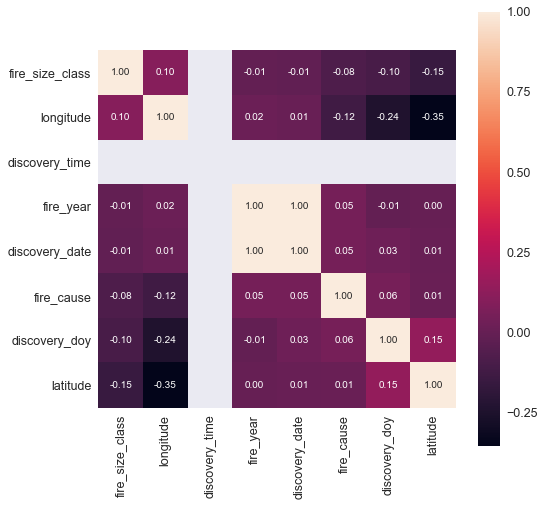

In [109]:
# Fire size correlation matrix

fix, ax = plt.subplots(figsize=(8,8))

corrmat = df.corr()
k = 10     #  number of variables for heatmap
cols = corrmat.nlargest(k, 'fire_size_class')['fire_size_class'].index
cm = np.corrcoef(df[cols].values.T)

sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

<div style="text-align: right">(<a href="#contents">home</a>) </div>

<a name="feature-engineering"></a>
## Feature engineering

In [110]:
# Longittude and latitude are normally used together; let's create a new column that combines them

df['longlat'] = df['longitude'] * df['latitude']

# We know time of year and the location play a role in fires

df['timelocation'] = df['longlat'] * df['discovery_time'] * df['discovery_date']

# Check out correlations

df.corr()['fire_size_class'].sort_values(ascending = False)

fire_size_class    1.000000
longlat            0.137969
longitude          0.104096
timelocation       0.068135
discovery_time     0.000827
fire_year         -0.010248
discovery_date    -0.013904
fire_cause        -0.079386
discovery_doy     -0.098910
latitude          -0.150071
Name: fire_size_class, dtype: float64

In [111]:
df['cause_timelocation'] = df['fire_cause'] * df['timelocation']

# Check out correlations

df.corr()['fire_size_class'].sort_values(ascending = False)

fire_size_class       1.000000
longlat               0.137969
longitude             0.104096
cause_timelocation    0.089694
timelocation          0.068135
discovery_time        0.000827
fire_year            -0.010248
discovery_date       -0.013904
fire_cause           -0.079386
discovery_doy        -0.098910
latitude             -0.150071
Name: fire_size_class, dtype: float64

In [112]:
df['doy_time_location'] = df['discovery_doy'] * df['timelocation']

# Check out correlations

df.corr()['fire_size_class'].sort_values(ascending = False)

fire_size_class       1.000000
longlat               0.137969
doy_time_location     0.122538
longitude             0.104096
cause_timelocation    0.089694
timelocation          0.068135
discovery_time        0.000827
fire_year            -0.010248
discovery_date       -0.013904
fire_cause           -0.079386
discovery_doy        -0.098910
latitude             -0.150071
Name: fire_size_class, dtype: float64

Let's also create some polynomial features:

In [114]:
df.isnull().sum()

fire_year                  0
discovery_date             0
discovery_doy              0
discovery_time        882638
datetime                   0
fire_date                  0
fire_cause                 0
latitude                   0
longitude                  0
state                      0
fire_size_class            0
longlat                    0
timelocation          882638
cause_timelocation    882638
doy_time_location     882638
dtype: int64

In [115]:
df.columns

Index(['fire_year', 'discovery_date', 'discovery_doy', 'discovery_time',
       'datetime', 'fire_date', 'fire_cause', 'latitude', 'longitude', 'state',
       'fire_size_class', 'longlat', 'timelocation', 'cause_timelocation',
       'doy_time_location'],
      dtype='object')

Looks like we can't use any of the time columns because we have so many nulls:

In [116]:
# Create polynomial features excluding year and date

features = ['fire_year', 'discovery_date', 'discovery_doy',
       'datetime','fire_cause', 'latitude', 'longitude', 'longlat']

X = df[features]
y = df['fire_size_class']

In [117]:
poly = PolynomialFeatures(include_bias = False)
X_poly = poly.fit_transform(X)

df = pd.DataFrame(data = X_poly, columns = poly.get_feature_names(features))

# Add target back

df['fire_size_class'] = y

In [118]:
df.corr()['fire_size_class'].sort_values(ascending = False)

fire_size_class                 1.000000
datetime longlat                0.168762
datetime longitude              0.156197
discovery_doy longlat           0.146281
fire_year longlat               0.138037
discovery_date longlat          0.138000
longlat                         0.137969
latitude longitude              0.137969
latitude longlat                0.124861
discovery_doy longitude         0.122862
fire_cause longlat              0.117077
fire_year longitude             0.104200
discovery_date longitude        0.104146
longitude                       0.104096
fire_cause longitude            0.097933
fire_year                      -0.010248
fire_year^2                    -0.010287
fire_year discovery_date       -0.011108
discovery_date                 -0.013904
discovery_date^2               -0.013915
fire_cause^2                   -0.063004
discovery_doy^2                -0.069718
fire_cause                     -0.079386
discovery_date fire_cause      -0.079404
fire_year fire_c

Create a heatmap that includes all of the polynomial features:

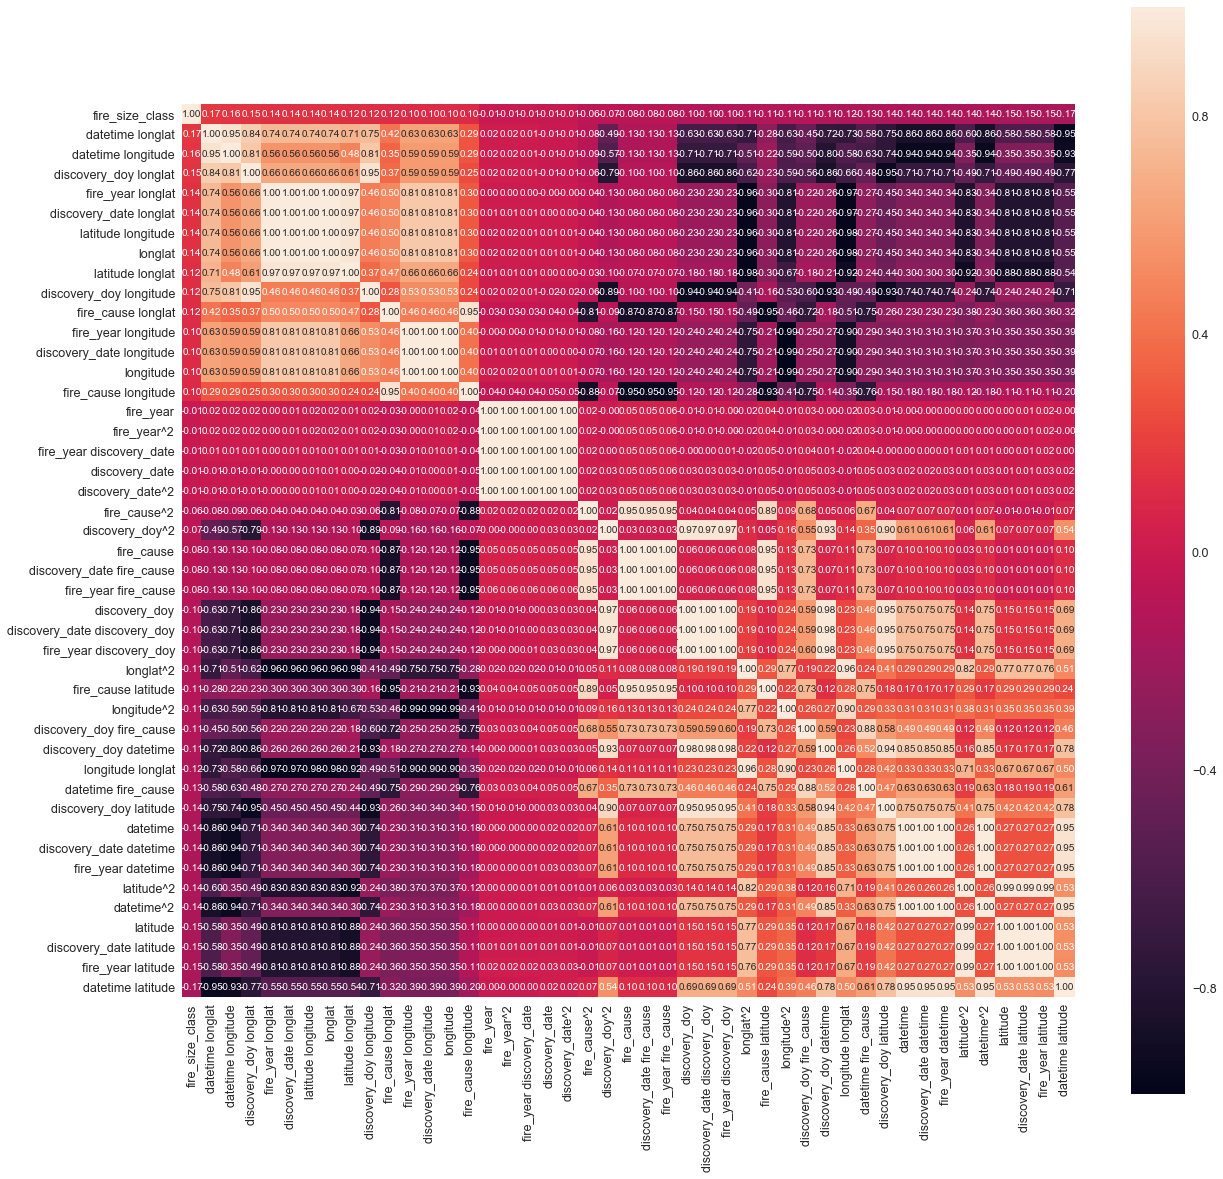

In [119]:
#correlation matrix including the polynomial features

fix, ax = plt.subplots(figsize=(20,20))
corrmat = df.corr()
k = 50         #    number of variables for heatmap
cols = corrmat.nlargest(k, 'fire_size_class')['fire_size_class'].index
cm = np.corrcoef(df[cols].values.T)

sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

It's clear that this dataframe is enormous and therefore, too time consuming to run all models on this dataframe, let's randomly select a subset from each year to reduce the size of the dataframe.

In [120]:
df.head()

fire_year  discovery_date  discovery_doy   datetime  fire_cause   latitude  \
0     2005.0       2453403.5           33.0   200533.0         7.0  40.036944   
1     2004.0       2453137.5          133.0  2004133.0         6.0  38.933056   
2     2004.0       2453156.5          152.0  2004152.0         3.0  38.984167   
3     2004.0       2453184.5          180.0  2004180.0         6.0  38.559167   
4     2004.0       2453184.5          180.0  2004180.0         6.0  38.559167   

    longitude      longlat  fire_year^2  fire_year discovery_date  \
0 -121.005833 -4844.703826    4020025.0              4.919074e+09   
1 -120.404444 -4687.712925    4016016.0              4.916088e+09   
2 -120.735556 -4706.775021    4016016.0              4.916126e+09   
3 -119.913333 -4623.758206    4016016.0              4.916182e+09   
4 -119.933056 -4624.518679    4016016.0              4.916182e+09   

        ...         fire_cause latitude  fire_cause longitude  \
0       ...                  280.258611           -847.040833   
1       ...                  233.598333           -722.426667   
2       ...                  116.952500           -362.206667   
3       ...                  231.355000           -719.480000   
4       ...                  231.355000           -719.598333   

   fire_cause longlat   latitude^2  latitude longitude  latitude longlat  \
0       -33912.926782  1602.956920        -4844.703826    -193967.137908   
1       -28126.277550  1515.782815        -4687.712925    -182506.987760   
2       -14120.325063  1519.765251        -4706.775021    -183489.701895   
3       -27742.549235  1486.809334        -4623.758206    -178288.263300   
4       -27747.112071  1486.809334        -4624.518679    -178317.586496   

    longitude^2  longitude longlat     longlat^2  fire_size_class  
0  14642.411700      586237.423696  2.347116e+07                0  
1  14497.230241      564421.470435  2.197465e+07                0  
2  14577.074376      568275.097050  2.215373e+07                0  
3  14379.207510      554450.258973  2.137914e+07                0  
4  14383.937816      554632.655616  2.138617e+07                0  

[5 rows x 45 columns]

In [121]:
df['fire_year'].unique()

array([2005., 2004., 2006., 2008., 2002., 2007., 2009., 2001., 2003.,
       1992., 1993., 1994., 1995., 1996., 1997., 1998., 1999., 2000.,
       2010., 2011., 2012., 2013., 2014., 2015.])

In [122]:
df = df.groupby('fire_year').apply(lambda x: x.sample(10_000)).reset_index(drop=True)

In [123]:
df.shape

(240000, 45)

<div style="text-align: right">(<a href="#contents">home</a>) </div>

<a name="model-evaluation"></a>
## Model evaluation

[0.5881875, 0.6269791666666666, 0.6005989583333333, 0.58134375, 0.6092, 0.6099]
[0.5834583333333333, 0.612625, 0.5931666666666666, 0.5760625, 0.6115, 0.6182]


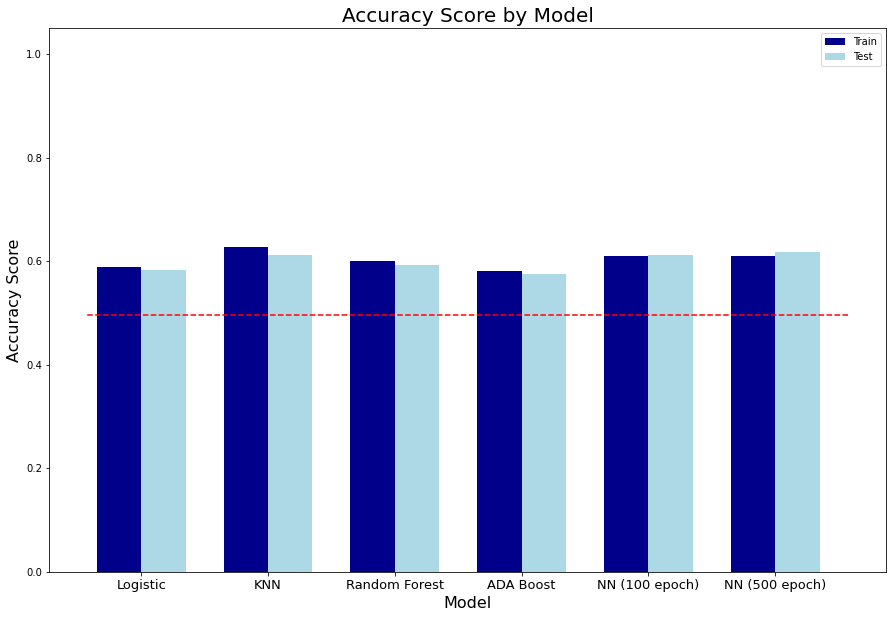

In [5]:
# Model comparison graphs

train_scores = [0.5881875, 0.6269791666666666, 0.6005989583333333, 0.58134375, 0.6092, 0.6099]
test_scores = [0.5834583333333333, 0.612625, 0.5931666666666666, 0.5760625, 0.6115, 0.6182]

N = 6
ind = np.arange(N)  # the x locations for the groups

width = 0.35
fig, ax = plt.subplots(figsize = (15, 10))
rects1 = ax.bar(ind, train_scores, width, color='darkblue')
rects2 = ax.bar(ind + width, test_scores, width, color='lightblue')
line1 = plt.plot([5.75,-0.25], [0.496479,0.496479], color = "red", linestyle='--', label='baseline')

ax.set_xlabel('Model', fontsize = 16)
ax.set_ylabel('Accuracy Score', fontsize = 16)
ax.set_ylim(0, 1.05)
ax.set_xticks(ind + width / 2)
ax.set_xticklabels(('Logistic', 'KNN', 'Random Forest', 'ADA Boost', 'NN (100 epoch)', 'NN (500 epoch)'), wrap = True, fontsize = 13)
ax.set_title('Accuracy Score by Model', fontsize = 20)
ax.legend((rects1[0], rects2[0]), ('Train', 'Test'), loc = 'upper right')

print(train_scores)
print(test_scores)

<div style="text-align: right">(<a href="#contents">home</a>) </div>

<a name="modeling"></a>
## Modeling

In [124]:
# Set features and target variables

X = df.drop(['fire_size_class'], axis = 1)
y = df['fire_size_class']

In [125]:
# Set up our train-test split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42, stratify = y)

Our baseline estimator:

In [126]:
y_test.value_counts(normalize = True)

1    0.496479
0    0.359396
2    0.116021
3    0.014896
4    0.007375
5    0.003896
6    0.001937
Name: fire_size_class, dtype: float64

In [127]:
df.shape

(240000, 45)

In [129]:
X_train.shape

(192000, 44)

In [130]:
y_train.shape

(192000,)

Let's train 4 models using Gridsearch for hyperparameter tuning: <strong>Logistic Regression, $k$NN, Random Forest</strong> and <strong>ADAboost</strong>

<div style="text-align: right">(<a href="#contents">home</a>) </div>

<a name="logistic-regression"></a>
### Logistic Regression

In [42]:
# Establish our pipeline

pipe_lr = Pipeline([('sc', StandardScaler()),
                       ('pca', PCA(random_state = 42)),
                       ('lr', LogisticRegression())])

# Define our parameters

params_lr = {
    'pca__n_components': range(1, 36, 5),
    'lr__penalty':      ['l2', 'l1'],
    'lr__C':            [.5, .01, 1],
    'lr__random_state': [42]
}

# Instantitate our GridSearch

gs_lr = GridSearchCV(pipe_lr, 
                        param_grid=params_lr,
                        cv=5,
                        n_jobs=2,
                        verbose=1)

# And fit it to the training data

gs_lr.fit(X_train, y_train)

print(f'GridSearch Best Params: {gs_lr.best_params_}')
print('Train Score:', gs_lr.score(X_train, y_train))
print('Validation Score:', gs_lr.score(X_test, y_test))

Fitting 5 folds for each of 42 candidates, totalling 210 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
/Users/mariamjaved/anaconda3/lib/python3.6/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
/Users/mariamjaved/anaconda3/lib/python3.6/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:  3.1min
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed: 10.2min
[Parallel(n_jobs=2)]: Done 210 out of 210 | elapsed: 10.5min finished
/Users/mariamjaved/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (sta

GridSearch Best Params: {'lr__C': 1, 'lr__penalty': 'l2', 'lr__random_state': 42, 'pca__n_components': 31}
Train Score: 0.5881875
Validation Score: 0.5834583333333333


<div style="text-align: right">(<a href="#contents">home</a>) </div>

<a name="knn"></a>
### $k$NN

In [ ]:
# Set up our pipeline

pipe_knn = Pipeline([('sc', StandardScaler()),
                     ('pca', PCA(random_state = 42)),
                     ('knn', KNeighborsClassifier())])

# Define its parameters

params_knn = {
    'pca__n_components': range(1, 44, 5),
    'knn__n_neighbors': range(1, 50, 5)
}

# Instantiate our GridSearch

gs_knn = GridSearchCV(pipe_knn,
                      param_grid=params_knn,
                      cv=5,
                      n_jobs=2,
                      verbose=1)

# And fit it to the data

gs_knn.fit(X_train, y_train)

print(f'GridSearch Best Params: {gs_knn.best_params_}')

In [132]:
print('Train Score:', gs_knn.score(X_train, y_train))
print('Test Score:', gs_knn.score(X_test, y_test))

Train Score: 0.6269791666666666
Test Score: 0.612625


<div style="text-align: right">(<a href="#contents">home</a>) </div>

<a name="random-forest"></a>
### Random forest

In [133]:
# Set up our pipeline

pipe_rf = Pipeline([('sc', StandardScaler()),
                    ('pca', PCA(random_state = 42)),
                    ('rf', RandomForestClassifier(random_state = 42))])

# Define its parameters

params_rf = {'pca__n_components': range(1, 44, 10),
             'rf__n_estimators': [25, 50, 100],
             'rf__criterion':    ['gini'],
             'rf__max_depth':    [3, 5]}

# Instantiate our GridSearch

gs_rf = GridSearchCV(pipe_rf,
                     param_grid=params_rf,
                     cv=5,
                     n_jobs=2,
                     verbose=1)

# Fit it to the training data

gs_rf.fit(X_train, y_train)

# Check our the scores

print(f'GridSearch Best Params: {gs_rf.best_params_}')
print('Train Score:', gs_rf.score(X_train, y_train))
print('Test Score:', gs_rf.score(X_test, y_test))

Fitting 5 folds for each of 30 candidates, totalling 150 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:  3.5min
[Parallel(n_jobs=2)]: Done 150 out of 150 | elapsed: 51.0min finished


GridSearch Best Params: {'pca__n_components': 31, 'rf__criterion': 'gini', 'rf__max_depth': 5, 'rf__n_estimators': 50}
Train Score: 0.6005989583333333
Test Score: 0.5931666666666666


<div style="text-align: right">(<a href="#contents">home</a>) </div>

<a name="adaboost"></a>
### ADAboost

In [139]:
# Set up our pipeline

pipe_ada = Pipeline([('sc', StandardScaler()),
                    ('pca', PCA(random_state = 42)),
                    ('ada', AdaBoostClassifier(base_estimator = DecisionTreeClassifier()))])

# Define its parameters

params_ada={
    'pca__n_components': range(1, 44, 10),
    'ada__n_estimators': [50,100],
    'ada__base_estimator__max_depth': [1,2]
}

# Instantiate our GridSearch

gs_ada = GridSearchCV(pipe_ada,
                        param_grid=params_ada, 
                        cv=5,
                        verbose = 1)

# Fit it to the training data

gs_ada.fit(X_train, y_train)

# Check our the scores
print(f'GridSearch Best Params: {gs_ada.best_params_}')
print('Train Score:', gs_ada.score(X_train, y_train))
print('Test Score:', gs_ada.score(X_test, y_test))

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed: 612.0min finished


GridSearch Best Params: {'ada__base_estimator__max_depth': 2, 'ada__n_estimators': 50, 'pca__n_components': 21}
Train Score: 0.58134375
Test Score: 0.5760625


<div style="text-align: right">(<a href="#contents">home</a>) </div>